# Simulation of Belvarafenib and Cobimetinib inhibition in BRAF<sup>V600E</sup> melanoma cells using the MARM2 model

Here you can simulate the respose of BRAF<sup>V600E</sup> cells under different doses of RAF (belvarafenib) and MEK inhibitors (cobimetinib). 

**Note**: this code performs the simulation for steady state responses under different inhibitor conditions. Use the Jupyter Notebook *Simulate_Belva_Cobi_Traj_MARM2_BRAF_V600E.ipynb* to generate simulation results for time course trajectories. 

## Import of libraries
Importing libraries necessary to run MARM2 model simulations.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy as cp
import itertools
import os
from pathlib import Path

Changes to main file directory. This works provided the "main_dir" has the correct directory name and the cwd starts within the main file directory. This might require tweaking under some high performance computing setups.

In [2]:
main_dir = "MARM2_Andrew_8_24"
for i in Path().resolve().parents:
    if i.parts[-1] == main_dir:
        os.chdir(i)

Importing the MARM2 PySB model and the simulator.  

In [3]:
from pysb.simulator import ScipyOdeSimulator
from pysb.core import as_complex_pattern
from pysb.bng import generate_equations

from scripts.models.PRAFi_vs_RAFi import model

## User-defined experimental setup
In this section you can alter the setup of the experiment simulated by MARM2. First, you need to define the experimental setup of the pre-treatment phase and of the subsequent inhibitor dose phase. The variables needed for the pre-treatment phase are:

<b>Pretreatment_time (h)</b>: defines the duration of the pre-treatment phase.
    
For the treatment phase, you need to set the running time of simulation after inhibitor dose. This is done with the following variables:

<b>Simulation_time (h)</b>: define the simulation time after inhibitor dose. 

<b>N_time_points</b>: define the number of time points returned by each model simulation. 

1. **Pretreatment duration** in hours.

In [4]:
t_pretrt = 24

2. **Simulation time** in hours.

In [5]:
t_trt = 24

3. **Parameter set** selects which of the 50 best-fit parameter sets to use for the simulation. Set 0 is the best fit and 49 the worst.

In [6]:
param_set_index = 13

4. **N_time_points** defineds the number of time points returned by each individual model simulation

In [7]:
N_time_points = 97

## Generate model equations
PySB runs BioNetGen to generate the reaction network

In [8]:
generate_equations(model)

## Parameter set preparation

Loads and prepares the parameter sets described in Fr&ouml;hlich et al https://www.embopress.org/doi/full/10.15252/msb.202210988. While the RAF inhibitor for that paper was Vemurafenib the parameters of the inhibitor are altered to align it with Belvarafenib.

In [87]:
param_sets = pd.read_csv(Path('data/parameter_data/RTKERK_pRAF_EGF_EGFR_MEKi_PRAFi_RAFi.csv'), index_col=0)
# finds the parameters of the .csv file that correspond to Cobimetinib and Vemurafenib and maps them to MEKi and RAFi (respectively)
rename_dict = {}
for i in param_sets.columns:
    if "Cobimetinib" in i or "LY3009120" in i or "Vemurafenib" in i:
        rename_dict[i] = i.replace("Cobimetinib","MEKi").replace("LY3009120","PRAFi").replace("Vemurafenib","RAFi")
param_sets = param_sets.rename(columns = rename_dict)

# finds the parameters which are stored in .csv file but not in the model and removes them
csv_spec_params = set(param_sets.columns)-(set(param_sets.columns)&set([i.name for i in model.parameters]))
param_sets = param_sets.drop(csv_spec_params, axis=1)

# Removes preference against second inhibitor binding to model type 2 pan RAF inhibitor (Belvarafenib)
param_sets["ep_RAF_RAF_mod_RAFi_double_ddG"] = 0

params = param_sets.iloc[param_set_index].to_dict()

params['RAFi_0'] = 0.0
params['PRAFi_0'] = 0.0
#params['MEKi_0'] = 0.0

# These might give identical values to Vemurafenib
params['bind_PRAFi_RAF_dG'] = -4.29844662
params['bind_PRAFi_RAF_kf'] = 3.07021176

print(params)

{'CRAF_0': 11330.48931, 'bind_PRAFi_RAF_dG': -4.29844662, 'bind_PRAFi_RAF_kf': 3.07021176, 'bind_PRAFi_RAF_phi': 0.0, 'bind_RAF_RAF_dG': -2.376557048, 'bind_RAF_RAF_kf': 9085.129703, 'bind_RAF_RAF_phi': 0.0, 'bind_RAFi_RAF_dG': -4.298446618, 'bind_RAFi_RAF_kf': 3.07021176, 'bind_RAFi_RAF_phi': 0.0, 'ep_RAF_RAF_mod_RAFi_double_ddG': 0.0, 'ep_RAF_RAF_mod_RAFi_single_ddG': -5.697253636, 'ep_RAF_RAF_mod_pRAF_ddG': 9.137382107, 'RAFi_0': 0.0, 'PRAFi_0': 0.0}


## Simulations

First we define some utility functions that will be used below.
*Equilibrate* runs a model simulation till steady state for that parameter set.
*Get_species_index* find and retunrs the index of speies in the model given input specie patterns. 

In [88]:
def equilibrate(simulator, initials,verbose = True):
    """Simulate a model from given initial conditions until it reaches steady state"""
    scale = 10
    t_start = 10
    df = None
    tspan = np.geomspace(t_start, t_start * scale)
    while True:
        if verbose:
            print(f"    at t={tspan[-1]:<5.3g} ... ", end='', flush=True)
        res = simulator.run(tspan=tspan, initials=initials)
        df = pd.concat([df, res.dataframe.iloc[1:]])
        initials = res.species[-1]
        close = np.isclose(
            *res.species[[-1,-2]].view(float).reshape(2,-1),
            rtol=1e-3
        )
        cs = np.sum(close)
        n = len(simulator.model.species)
        if verbose:
            print(f"{cs}/{n} species converged")
        if np.all(close):
            break
        tspan *= scale
    return df

In [89]:
def get_species_index(model, pattern):
    """Return the integer species number for a given species in the model"""
    pattern = as_complex_pattern(pattern)
    matches = [
        i for i, s in enumerate(model.species)
        if s.is_equivalent_to(pattern)
    ]
    n = len(matches)
    assert n == 1, f"Expected exactly one match, got {n}"
    return matches[0]

## Initial equilibrium
First we run the model from its baseline initial conditions until equilibrium is reached. For example protein synthesis/degradation, phosphorylation/dephosphorylation, and drug binding/unbinding all need to reach steady state to match the state of the cells in the experimental setup. There may be some time without visible progress as behind the scenes PySB runs BioNetGen to generate the reaction network and Cython to compile the resulting differential equations into efficient executable code.

In [90]:
sim = ScipyOdeSimulator(model,param_values=params) 
df_eq = equilibrate(sim, None)

    at t=100   ... 11/11 species converged


Now that the model has been simulated once and the actual molecular species have been enumerated, we can find the exact species numbers for the inhibitors. These are needed so that their concentrations can be overridden in the model state for subsequent simulations.

In [91]:
PRAFi_index = get_species_index(model, model.monomers.PRAFi(raf=None)**model.compartments.CP)
RAFi_index = get_species_index(model, model.monomers.RAFi(raf=None)**model.compartments.CP)

## Inhibitor pre-treatment

We take the final state of the equilibration simulation and use it as the initial state of this new simulation, overriding the RAFi and MEKi concentrations with pre-specified values.

In [92]:
initials_pre = df_eq.iloc[-1, :len(model.species)].copy()
initials_pre[PRAFi_index] = 0.0
initials_pre[RAFi_index] = 0.0

#fixed time pre-treatment simulation
tspan_pretrt = np.linspace(0, t_pretrt, N_time_points)
df_pre=sim.run(tspan=tspan_pretrt, initials=initials_pre.to_list()).dataframe

#run pre-tretment to steady state instead of using specified time  
#df_pre = equilibrate(sim, initials_pre)

In case the previous simulation was run to steady state, we want to retain only the first t_pretrt hours of pre-treatment plus the state at final equilibrium. So we cut the time series down using a Pandas slice operation and adjust the remaining time values to begin at -pre_time_max.

In [93]:
if (len(df_pre.loc[:t_pretrt])<len(df_pre)):
   df_pre_tmp = df_pre.loc[:t_pretrt]
   df_pre_tmp.iloc[-1] = df_pre.iloc[-1]
   df_pre= df_pre_tmp
df_pre['time'] = df_pre.index
df_pre['time'] = df_pre['time']-t_pretrt
df_pre['time'].iloc[-1] = 0
df_pre.reset_index(drop=True, inplace=True)
df_pre.set_index('time', inplace=True)

## Inhibitor treatment

We run another simulation starting from the final state of the pre-treatment simulation, overriding the MEKi and 
RAFi concentrations with a range of inhibitor values. Each condition is run to equilibrium.

In [94]:
#set the dilution range for the RAF inhibitor, which is x axis
PRAFi_dil=np.logspace(-2.25,.5, 9); #uM
PRAFi_dil = np.concatenate(([0],PRAFi_dil))
#set the dilution range for the MEK inhibitor, which is y axis
RAFi_dil=np.logspace(-2.25,.5, 9); #uM
RAFi_dil = np.concatenate(([0],RAFi_dil))

In [95]:
def simulate_inhib_dose(dose_info):
    params.update({'PRAFi_0': dose_info[0],'RAFi_0': dose_info[1],'kbind_RAF_RAF':dose_info[2]});
    #run this to assure model is run to steady_ state, 
    res = equilibrate(ScipyOdeSimulator(model,param_values=cp.deepcopy(params)) , None,verbose=False)
    print(1,end="")
    return [dose_info, res.iloc[-1]]

In [99]:
#define observables to plot
plt_obs=['bound_RAFi', 'free_RAFi', 'bound_PRAFi', 'free_PRAFi','bound_CRAF_obs'];
bound_RAFi_rat = []
bound_fakePRAFi_rat = []
bound_PRAFi_rat = []
bound_CRAF_r = []
bound_CRAF_p = []
bound_CRAF_pp = []
RAFis = np.logspace(-2.25,.5)
print(RAFis)
for i in RAFis:
    result_low = simulate_inhib_dose([0,i,0])[1][plt_obs]
    result_high = simulate_inhib_dose([0,i,1000])[1][plt_obs]
    bound_RAFi_rat.append(result_high['bound_RAFi']/result_low['bound_RAFi'])
    bound_CRAF_r.append(result_high['bound_CRAF_obs'])
    bound_CRAF_r.append(result_low['bound_CRAF_obs'])

for i in RAFis:
    result_low = simulate_inhib_dose([i,0,0])[1][plt_obs]
    result_high = simulate_inhib_dose([i,0,1000])[1][plt_obs]
    bound_PRAFi_rat.append(result_high['bound_PRAFi']/result_low['bound_PRAFi'])
    bound_CRAF_p.append(result_high['bound_CRAF_obs'])
    bound_CRAF_p.append(result_low['bound_CRAF_obs'])
save = params['ep_RAF_RAF_mod_RAFi_single_ddG']
params.update({'ep_RAF_RAF_mod_RAFi_single_ddG': 0})
for i in RAFis:
    result_low = simulate_inhib_dose([0,i,0])[1][plt_obs]
    result_high = simulate_inhib_dose([0,i,1000])[1][plt_obs]
    bound_fakePRAFi_rat.append(result_high['bound_RAFi']/result_low['bound_RAFi'])
    bound_CRAF_pp.append(result_high['bound_CRAF_obs'])
    bound_CRAF_pp.append(result_low['bound_CRAF_obs'])
params.update({'ep_RAF_RAF_mod_RAFi_single_ddG': save})
print(np.sum(np.array(bound_CRAF_r) - np.array(bound_CRAF_p)))
print(np.sum(np.array(bound_CRAF_r) - np.array(bound_CRAF_pp)))
print(bound_CRAF_p)

#for i in range(len(results)):
#    dr_df.loc[results[i][0]] = results[i][1][plt_obs]

[0.00562341 0.00639915 0.0072819  0.00828643 0.00942952 0.01073031
 0.01221054 0.01389495 0.01581174 0.01799294 0.02047503 0.02329952
 0.02651364 0.03017115 0.0343332  0.0390694  0.04445895 0.05059197
 0.05757104 0.06551286 0.07455023 0.08483429 0.09653702 0.10985411
 0.12500828 0.14225293 0.16187645 0.184207   0.209618   0.2385344
 0.27143976 0.30888436 0.35149437 0.39998234 0.45515914 0.51794747
 0.58939733 0.67070356 0.76322583 0.86851137 0.98832085 1.12465782
 1.27980221 1.45634848 1.65724896 1.88586328 2.14601451 2.44205309
 2.77892964 3.16227766]
111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111-1.0875799483223147e-08
-1.1012042833158375e-08
[0.7945057644609699, 0.0, 0.7945057642637329, 0.0, 0.7945057629645897, 0.0, 0.794505764119122

In [ ]:
!conda env export --name quant_bio

[1.4861518836198166, 1.4322576057655585, 1.3826141787512578, 1.3402931209443651, 1.2978689688488572, 1.2595101693569497, 1.2241884418589197, 1.1937420413230135, 1.1665323743507416, 1.1423862637905216, 1.1211007234060748, 1.1024596157578572, 1.0862330948477432, 1.072197237085266, 1.060134350552883, 1.0498269161642815, 1.0410753541534727, 1.0336959671307475, 1.0275076546103998, 1.0223518991669867, 1.018081798902153, 1.0145652598893735, 1.011685366359561, 1.0093396164720496, 1.0074384361779916, 1.0059049558510362, 1.0046733174582516, 1.0036884785017928, 1.0029037991967573, 1.002280914836314, 1.0017879442090767, 1.0013989662146463, 1.0010927873973137, 1.000852454309272, 1.0006641461724703, 1.0005168251459973, 1.0004017323371992, 1.0003119067103747, 1.000242185917422, 1.0001878047265824, 1.00014566257094, 1.0001128658643594, 1.0000874164033415, 1.0000676160737787, 1.000052299410718, 1.0000405276591644, 1.0000313489997683, 1.0000242432724045, 1.0000187441266986, 1.000014489961371]
[1.0000000

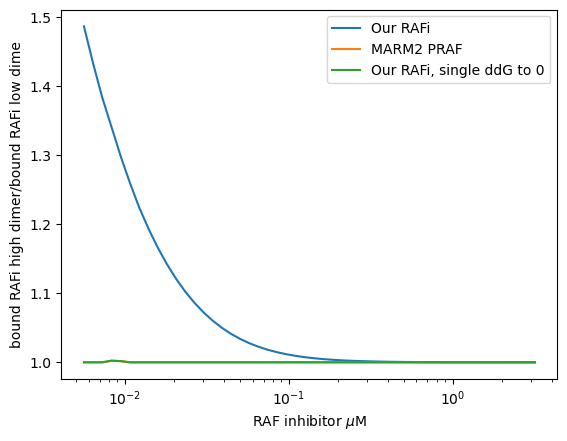

In [106]:
plt.plot(RAFis,bound_RAFi_rat,label = "Our RAFi")
plt.plot(RAFis,bound_PRAFi_rat,label = "MARM2 PRAF")
plt.plot(RAFis,bound_fakePRAFi_rat,label = "Our RAFi, single ddG to 0")
plt.xscale('log')
plt.xlabel("RAF inhibitor $\mu$M")
plt.ylabel("bound RAFi high dimer/bound RAFi low dime")
plt.legend()
print(bound_RAFi_rat)
print(bound_PRAFi_rat)
print(bound_fakePRAFi_rat)